# Airbnb data exploration

In this notebook we try to describe and explore the features of public datasets.

To look for more information about this public datasets look here: http://insideairbnb.com/get-the-data.html




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from utils import download_datasets

In [25]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')

datasets_cities = ['seattle', 'boston', 'austin']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: austin_reviews.csv.gz, in cache


In [26]:
#Reading files


listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz')]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [28]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6196350900142947


In [29]:
#Computing scalers.
min_date = calendar.date.min()
max_date = calendar.date.max()

min_price = calendar.price.min()
max_price = calendar.price.max()

scaler_date = MinMaxScaler()
scaler_price = MinMaxScaler()

scaler_date.fit([[min_date.timestamp()], [max_date.timestamp()]])
scaler_price.fit([[min_price], [max_price]])


def slope_value(data):
  x = data.copy()
  x['date'] = x['date'].apply(lambda x: float(x.timestamp()))
  x = x.dropna()
  
  if x.shape[0] == 0:
    return np.nan
  
  X = x['date'].values.reshape(x['date'].shape[0], 1)
  y = x['price'].values.reshape(x['price'].shape[0], 1)
  
  X = scaler_date.transform(X)
  y = scaler_price.transform(y)
  
  lm = LinearRegression(n_jobs=-1)
  lm.fit(X, y)
  
  return lm.coef_[0][0]


def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.max()/x.price.min()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

def std_metric(data):
    return data.price.std()
    
def mean_metric(data):
    return data.price.mean()

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
slope = calendar.groupby('listing_id').apply(lambda x: slope_value(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))
std = calendar.groupby('listing_id').apply(lambda x: std_metric(x))
mean = calendar.groupby('listing_id').apply(lambda x: mean_metric(x))

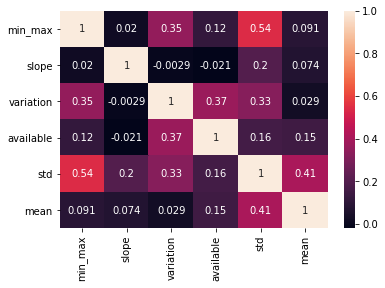

In [31]:
min_max.name = "min_max"
slope.name ="slope"
variation.name = "variation"
available.name = "available"
std.name = "std"
mean.name = "mean"

combined_metrics = pd.concat([min_max, slope, variation, available, std, mean], axis=1)
scaler = MinMaxScaler()
combined_metrics = combined_metrics.dropna()
combined_metrics[combined_metrics.columns] = scaler.fit_transform(combined_metrics[combined_metrics.columns])
corr_matrix = combined_metrics.corr()
combined_metrics = combined_metrics.drop(['std', 'min_max', 'variation', 'slope', 'available'], axis=1)
sns.heatmap(corr_matrix, annot=True);

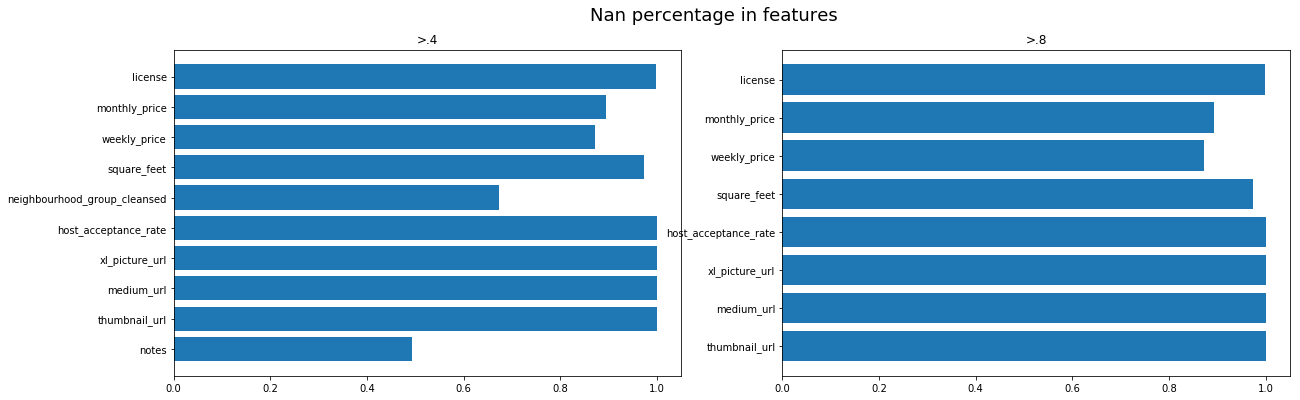

In [32]:
#Getting null % for each feature

total_size = listings.shape[0]

labels_ = [[],[]]
values_ = [[],[]]


for feature in listings:
    nulls_percentage = listings[feature].isna().sum()/total_size
    if nulls_percentage > .4:
        labels_[0] += [feature]
        values_[0] += [nulls_percentage]
    if nulls_percentage > .8:
        labels_[1] += [feature]
        values_[1] += [nulls_percentage]
    



plt.figure(1, figsize=(20, 6))
plt.suptitle('Nan percentage in features', fontsize=18)
plt.xticks(rotation='vertical')
plt.subplot(121)
plt.title('>.4')
plt.barh(labels_[0], values_[0])
plt.subplot(122)
plt.title('>.8')
plt.barh(labels_[1], values_[1])
plt.show();

In [33]:
[print(labels_[1][i], ":", values_[1][i]) for i in range(len(values_[1]))];
listings_dropna = listings.drop(labels_[1], axis=1)

thumbnail_url : 1.0
medium_url : 1.0
xl_picture_url : 1.0
host_acceptance_rate : 1.0
square_feet : 0.9741624951867539
weekly_price : 0.8729303041971506
monthly_price : 0.8940315748941086
license : 0.9991143627262226


In [34]:
scaler = MinMaxScaler()
num_listings = listings_dropna.select_dtypes(include=np.number).dropna()
cols = list(set(num_listings.columns) - set(['id', 'scrape_id', 'host_id']))
num_listings[cols] = scaler.fit_transform(num_listings[cols])
num_listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20523.0,1.500862e+07,7.877103e+06,2.265000e+03,8.173136e+06,1.669155e+07,2.160886e+07,2.769813e+07
scrape_id,20523.0,2.018082e+13,1.174566e+06,2.018081e+13,2.018081e+13,2.018082e+13,2.018082e+13,2.018082e+13
host_id,20523.0,4.550954e+07,5.075500e+07,2.000000e+01,6.991842e+06,2.426302e+07,6.885439e+07,2.082981e+08
host_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
host_total_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
latitude,20523.0,5.272298e-01,4.396773e-01,0.000000e+00,1.020921e-02,6.941332e-01,9.928735e-01,1.000000e+00
longitude,20523.0,4.274888e-01,3.783737e-01,0.000000e+00,2.013789e-03,4.796052e-01,4.810378e-01,1.000000e+00
accommodates,20523.0,1.096169e-01,9.744102e-02,0.000000e+00,3.703704e-02,7.407407e-02,1.481481e-01,1.000000e+00
bathrooms,20523.0,1.020102e-01,5.200162e-02,0.000000e+00,7.407407e-02,7.407407e-02,1.111111e-01,1.000000e+00
bedrooms,20523.0,9.013417e-02,6.476545e-02,0.000000e+00,5.882353e-02,5.882353e-02,1.176471e-01,1.000000e+00


In [35]:
combined_metrics.index.name = 'id'

In [36]:
num_listings = num_listings.set_index('id')


In [37]:
result = pd.merge(combined_metrics, num_listings, on='id')

In [38]:
corr_matrix = result.corr()
corr_matrix.style.background_gradient()

,mean,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
mean,1,-0.106704,-0.00899636,0.125991,0.125991,-0.151296,0.093991,0.598283,0.566916,0.587965,0.547175,0.420942,0.0411207,-0.00122045,0.171375,0.139654,0.115793,0.146187,-0.133005,0.0355387,-0.0110932,0.0361889,-0.0199706,-0.0317372,0.0544534,-0.0654346,0.127244,-0.186404
scrape_id,-0.106704,1,0.000995841,0.193831,0.193831,0.845394,0.17551,-0.199803,-0.172928,-0.192284,-0.17363,-0.187076,-0.0197093,-0.00897274,-0.335867,-0.242946,-0.183884,-0.101681,0.0704597,-0.184907,-0.12016,-0.0846907,-0.097105,-0.111949,-0.0940885,-0.168971,0.21068,0.152877
host_id,-0.00899636,0.000995841,1,-0.0877558,-0.0877558,-0.0140643,0.0278209,0.0521719,0.0288826,0.0274396,0.0566561,0.0705914,-0.0527863,-0.00693309,-0.0057943,0.00768526,0.0114194,-0.0526055,-0.201373,-0.0258635,-0.0256221,-0.0236328,-0.0263542,-0.0326859,-0.0108295,-0.0162316,-0.108199,0.153419
host_listings_count,0.125991,0.193831,-0.0877558,1,1,0.100572,0.150749,-0.00518949,0.015704,-0.00535092,-0.0188904,-0.0315309,-0.0109262,-0.00219681,0.127741,0.145134,0.143252,0.0428206,-0.132489,-0.19501,-0.187047,-0.0373173,-0.241718,-0.221638,-0.03915,-0.200915,0.823653,-0.165055
host_total_listings_count,0.125991,0.193831,-0.0877558,1,1,0.100572,0.150749,-0.00518949,0.015704,-0.00535092,-0.0188904,-0.0315309,-0.0109262,-0.00219681,0.127741,0.145134,0.143252,0.0428206,-0.132489,-0.19501,-0.187047,-0.0373173,-0.241718,-0.221638,-0.03915,-0.200915,0.823653,-0.165055
latitude,-0.151296,0.845394,-0.0140643,0.100572,0.100572,1,-0.377442,-0.189387,-0.174737,-0.197344,-0.178379,-0.147582,-0.0338352,-0.00941191,-0.330244,-0.219144,-0.155826,-0.114465,0.102859,-0.11974,-0.0749155,-0.0238812,-0.0611666,-0.0606955,-0.0163888,-0.101139,0.152975,0.191544
longitude,0.093991,0.17551,0.0278209,0.150749,0.150749,-0.377442,1,0.00264168,0.0224491,0.0303576,0.0278128,-0.0523986,0.0284635,0.00180187,0.0262434,-0.0173915,-0.031672,0.0346047,-0.0675718,-0.10008,-0.0704013,-0.103116,-0.0555755,-0.082305,-0.132238,-0.106761,0.0833675,-0.0881367
accommodates,0.598283,-0.199803,0.0521719,-0.00518949,-0.00518949,-0.189387,0.00264168,1,0.627563,0.823257,0.858401,0.639668,-0.0433413,0.0108947,0.120588,0.0827739,0.0658646,0.124026,-0.086583,0.0320562,-0.000441692,0.0260239,0.0140999,-0.00676862,0.00809692,-0.0237557,-0.0308081,-0.0829207
bathrooms,0.566916,-0.172928,0.0288826,0.015704,0.015704,-0.174737,0.0224491,0.627563,1,0.703402,0.615213,0.440499,0.00269767,0.0117733,0.110768,0.0833428,0.0649235,0.116594,-0.13488,0.0506182,0.00795865,0.00503956,0.013407,-0.0070204,-0.0144601,5.54223e-05,-0.00120612,-0.177412
bedrooms,0.587965,-0.192284,0.0274396,-0.00535092,-0.00535092,-0.197344,0.0303576,0.823257,0.703402,1,0.769892,0.555977,-0.0103017,0.00978667,0.105679,0.0688556,0.049907,0.108161,-0.143443,0.0583873,0.0172896,0.014541,0.0381459,0.00859854,-0.0179824,0.00624179,-0.0315724,-0.182704


In [39]:
from sklearn.ensemble import RandomForestRegressor
result = result.dropna()
y = result['mean']
X = result.drop('mean', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regressor = RandomForestRegressor(n_jobs=-1)

regressor.fit(X=X_train, y=y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
from sklearn.metrics import mean_absolute_error
#y_pred = regressor.predict(X_test)




1.0000000000000002